# Codelab 03: Feature Extraction and Object Classification

## Part 1: Load data

In [6]:
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb

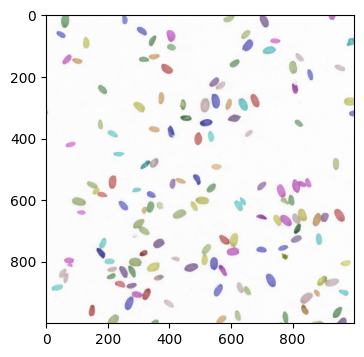

In [8]:
# Define path
labels_filepath = r'../example_images/seed_labels.tif'
img_filepath = r'../example_images/seed_img.JPG'

# Read images
seed_rois = imread(labels_filepath)
img = imread(img_filepath)

# Split channel
img_ch0 = img[:,:,0]
img_ch1 = img[:,:,1]
img_ch2 = img[:,:,2]

# Define a range to visulize
x_start = 1000
x_end = 2000
y_start = 1000
y_end = 2000

# Display label on top of the image
seed_img_overlay = label2rgb(seed_rois, image=img_ch1, bg_label=0, alpha=0.3, bg_color=(1, 1, 1))
plt.figure(figsize=(4, 4))
plt.imshow(seed_img_overlay[x_start:x_end, y_start:y_end])

## Part 2: Measure object properties

In [9]:
# Import regionprops_table from skimage.measure
from skimage.measure import regionprops_table

# Extract properties from the seed rois in the image channel 0
props_ch0 = regionprops_table(seed_rois, img_ch0, properties=['area', 
                                                              'intensity_mean',
                                                              'intensity_min',
                                                              'eccentricity',
                                                              'feret_diameter_max',
                                                              'perimeter',
                                                              'solidity',
                                                             ])
# Extract properties from the seed rois in the image channel 1
props_ch1 = regionprops_table(seed_rois, img_ch1, properties=['intensity_mean'])

In [10]:
# Import pandas
import pandas as pd

In [11]:
# Convert the properties to pandas dataframe
props_ch0_df = pd.DataFrame(props_ch0)
props_ch1_df = pd.DataFrame(props_ch1)

In [12]:
# Join the two dataframes
# lsuffix and rsuffix are used to differentiate the columns from the two dataframes
props_df = props_ch0_df.join(props_ch1_df, lsuffix='_ch0', rsuffix='_ch1')

In [13]:
# Display the first few rows of the dataframe with *.head() method
props_df.head()

,area,intensity_mean_ch0,intensity_min,eccentricity,feret_diameter_max,perimeter,solidity,intensity_mean_ch1
0,402.0,226.049751,201.0,0.883760,32.802439,80.669048,0.957143,200.823383
1,300.0,223.693333,201.0,0.835933,26.076810,67.012193,0.955414,192.440000
2,748.0,210.854278,180.0,0.793136,40.521599,104.669048,0.968912,178.549465
3,389.0,227.313625,203.0,0.872824,32.802439,78.183766,0.962871,195.681234
4,748.0,214.733957,183.0,0.803506,41.436699,105.740115,0.968912,181.863636


Text(0, 0.5, 'ch1 Intensity')

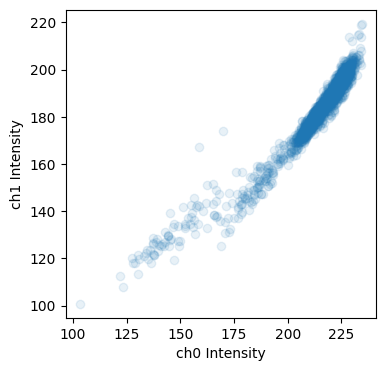

In [14]:
# Visulize the distribution of data points in color space

plt.figure(figsize=(4,4))
plt.plot(props_df['intensity_mean_ch0'], props_df['intensity_mean_ch1'], 'o', alpha=0.1)
plt.xlabel('ch0 Intensity')
plt.ylabel('ch1 Intensity')

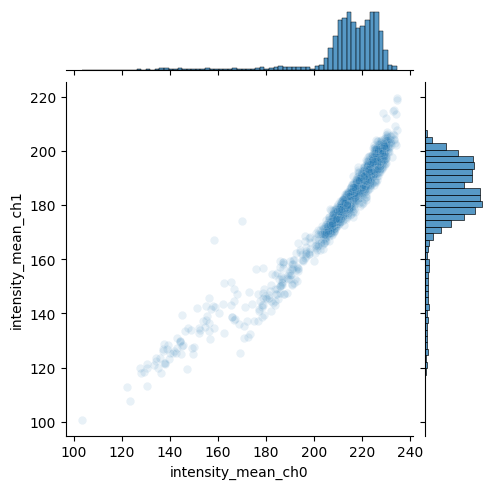

In [15]:
# You can also use the seaborn library, a higher level library that utilize pandas and matplotlib to plot graphs

# “Seaborn is a library for making statistical graphics in Python. It builds on top of matplotlib and integrates 
# closely with pandas data structures.”

# Import seaborn
import seaborn as sns

# Plot the joint distribution of the two channels
sns.jointplot(data=props_df, x="intensity_mean_ch0", y="intensity_mean_ch1",alpha=0.1, height=5)

<Axes: xlabel='intensity_mean_ch0', ylabel='intensity_mean_ch1'>

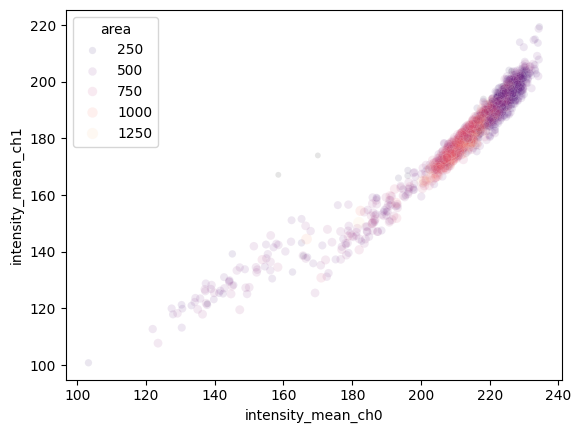

In [17]:
# But we are also interested in looking at the distribution of data points in other dimensions. 
# We can use other features of a scatter plot to represent other aspects of the data
sns.scatterplot(data=props_df, x="intensity_mean_ch0", y="intensity_mean_ch1", size="area", hue="area", palette='magma', alpha = 0.1)

## Part 3: Dimensional Reduction

### Sec01: Dimension Reduction with PCA

In [18]:
# Data scaling
props_data = props_df.values

# Import StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler object
std_scaler = StandardScaler()
# Fit and transform the data
props_data_scaled = std_scaler.fit_transform(props_data)

In [21]:
# Import PCA from sklearn
from sklearn.decomposition import PCA

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit and transform the scaled data
seed_pca = pca.fit(props_data_scaled).transform(props_data_scaled)

In [22]:
# Print the explained variance ratio
# Explined variance ratio is the ratio of the variance of the data points in the new space to the variance of the data points in the original space
print(
    "explained variance ratio: %s"
    % str(pca.explained_variance_ratio_)
)

explained variance ratio: [0.4366397  0.29541844]


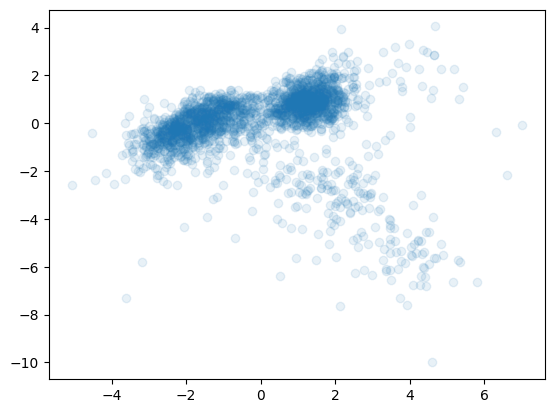

In [23]:
# Plot the data points in the new space
plt.scatter(seed_pca[:, 0], seed_pca[:, 1],alpha = 0.1)

### Sec02: Dimension Reduction with UMAP

In [24]:
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

In [25]:
np.random.seed(60)

In [26]:
reducer = umap.UMAP()

In [27]:
embedding = reducer.fit_transform(props_data_scaled)

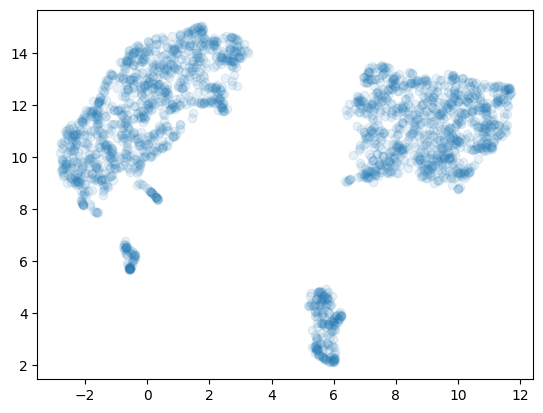

In [28]:
plt.scatter(embedding[:, 0], embedding[:, 1], alpha = 0.1)

## Part 4: Clustering/ Classification

### Sec01: K-mean

In [30]:
from sklearn.cluster import KMeans

In [31]:
n_clusters = 4
kmeans = KMeans(n_clusters= n_clusters, random_state=42).fit(embedding)

In [32]:
kmeans_prediction = kmeans.predict(embedding)

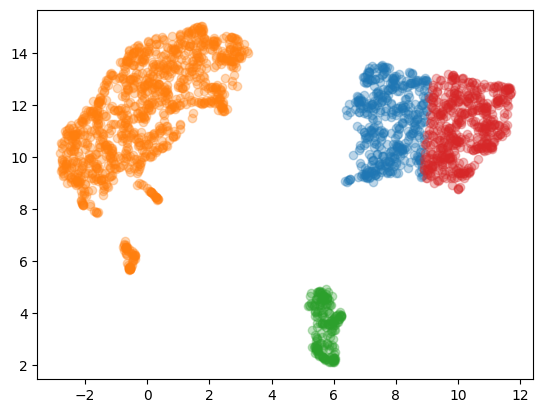

In [33]:
for i in range(n_clusters):
    plt.plot(embedding[:, 0][kmeans_prediction == i], embedding[:, 1][kmeans_prediction == i], 'o', alpha = 0.3)

### Sec02: HDBSCAN
How HDBSCAN works: https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [34]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(embedding)

HDBSCAN(min_cluster_size=15)

In [35]:
cluster_ids = np.unique(clusterer.labels_)
print(f'There are {len(cluster_ids)} clusters, with cluster ID: {cluster_ids}.')

There are 4 clusters, with cluster ID: [0 1 2 3].


Text(0.5, 1.0, 'UMAP Analysis Results, labelled by HDBSCAN cluster ID')

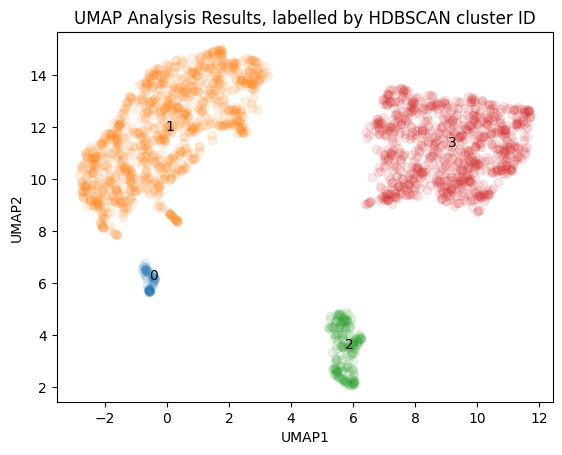

In [36]:
for cluster_id in cluster_ids:
    x = embedding[:, 0][clusterer.labels_ == cluster_id]
    y = embedding[:, 1][clusterer.labels_ == cluster_id]
    plt.scatter(x, y, alpha = 0.1)
    plt.text(np.mean(x), np.mean(y),str(cluster_id))
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Analysis Results, labelled by HDBSCAN cluster ID')

## Part 5: Visulization of the clustering results

In [37]:
props_df.shape[0]

2235

In [40]:
from tqdm import tqdm

# Check the original image for the clustering result
num_roi = props_df.shape[0]

roi_cluster_labels = np.zeros_like(seed_rois)

for roi_id in tqdm(range(num_roi)):
    # Get ROI of a single seed
    seed_roi = seed_rois == roi_id + 1

    # Add ROIs to the roi_cluster_labels, with label as cluster Id + 1 (+1 such that the label won't be background)
    roi_cluster_labels[seed_roi] = clusterer.labels_[roi_id] + 5

100%|██████████| 2235/2235 [00:30<00:00, 72.92it/s]


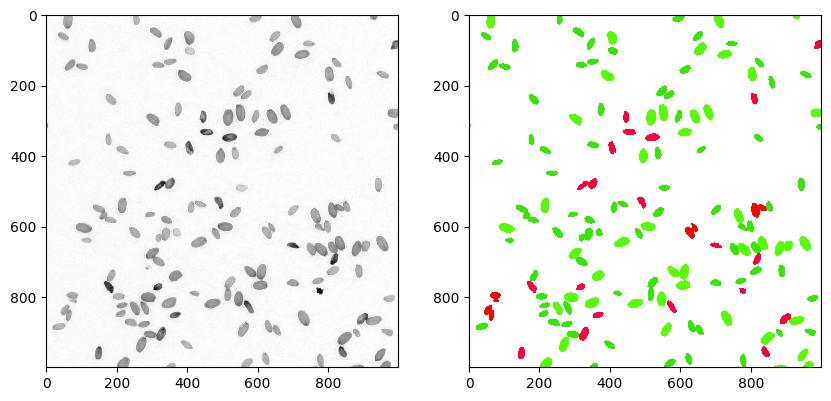

In [41]:
roi_cluster_labels_mask = np.ma.array(roi_cluster_labels, mask=roi_cluster_labels==0)
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(img_ch1[y_start: y_end, x_start: x_end], interpolation='none', cmap='gray')
plt.subplot(122)
plt.imshow(roi_cluster_labels_mask[y_start: y_end, x_start: x_end], interpolation='none', cmap='prism')

In [ ]:
# First import module napari
import napari

# Create an empty viewer object
viewer = napari.Viewer()

# Use viewer.add_image() and pass the image as a variable to visulize the image. Similar to that for matplotlib, set options:
#  * colormap as 'gray'
#  * interpolation (interpolation2d) is 'nearest' (which correspond to minimum interpolation) by default, so no need to specify 
#  * name as 'Raw Image'
viewer.add_image(img_ch0, colormap = 'red', name= 'Raw Image', blending= 'additive')
viewer.add_image(img_ch1, colormap = 'green', name= 'Raw Image', blending= 'additive')
viewer.add_image(img_ch2, colormap = 'blue', name= 'Raw Image', blending= 'additive')

viewer.add_labels(roi_cluster_labels)

In [ ]:
viewer.add_labels(seed_rois)

## Compare the color distribution of groups

In [42]:
# Add the cluster labels to the props_df
props_df.insert(0, "Cluster ID", clusterer.labels_)

In [43]:
props_df.head()

,Cluster ID,area,intensity_mean_ch0,intensity_min,eccentricity,feret_diameter_max,perimeter,solidity,intensity_mean_ch1
0,1,402.0,226.049751,201.0,0.883760,32.802439,80.669048,0.957143,200.823383
1,1,300.0,223.693333,201.0,0.835933,26.076810,67.012193,0.955414,192.440000
2,3,748.0,210.854278,180.0,0.793136,40.521599,104.669048,0.968912,178.549465
3,1,389.0,227.313625,203.0,0.872824,32.802439,78.183766,0.962871,195.681234
4,3,748.0,214.733957,183.0,0.803506,41.436699,105.740115,0.968912,181.863636


<Axes: xlabel='intensity_mean_ch0', ylabel='Density'>

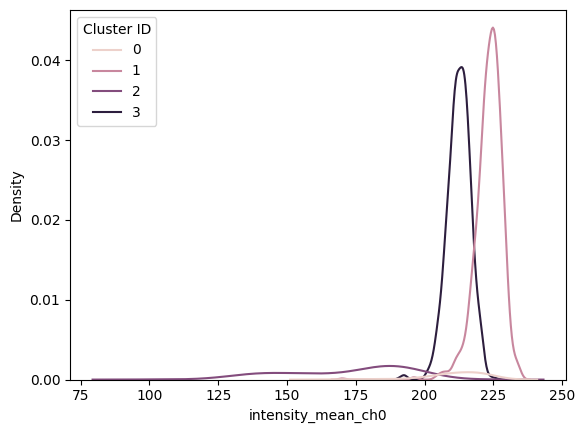

In [44]:
sns.kdeplot(data=props_df, x="intensity_mean_ch0", hue="Cluster ID")

<Axes: xlabel='area', ylabel='Density'>

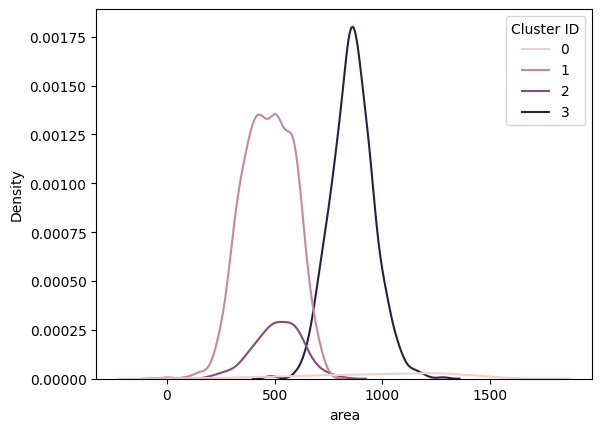

In [45]:
sns.kdeplot(data=props_df, x="area", hue="Cluster ID")